In [1]:
special_tokens = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']

def build_vocab(data):
    vocab = dict()
    # Initialize vocabularies with special tokens
    for token in special_tokens:
        vocab[token] = len(vocab)

    for sentence in data:
        for word in sentence.split():
            if word.lower() not in vocab: vocab[word.lower()] = len(vocab)
    
    return vocab

def tokenize(vocab, data):
    tok_data = []

    for sentence in data:
        sentence_tok = []
        sentence_tok.append(vocab['<SOS>'])
        for word in sentence.split():
            if word.lower() in vocab:
                sentence_tok.append(vocab[word.lower()])
            else:
                sentence_tok.append(vocab['<UNK>'])
        sentence_tok.append(vocab['<EOS>'])
        tok_data.append(sentence_tok)
    
    return tok_data

def pad_sentences(data, pad_token):
    max_len = max(len(sentence) for sentence in data)
    padded_data = []
    for sentence in data:
        while len(sentence) < max_len:
            sentence.append(pad_token)
        padded_data.append(sentence)
    return padded_data
from datasets import load_dataset

dataset = load_dataset("opus_books", 'en-fi')

import numpy as np
def dataset_to_numpy(dataset):
    finnish_sentences = []
    english_sentences = []
    
    for example in dataset:
        finnish_sentences.append(example['translation']['fi'])
        english_sentences.append(example['translation']['en'])
    
    return finnish_sentences, english_sentences
finnish_data, english_data = dataset_to_numpy(dataset['train'])

/Users/jonirajalaa/Documents/fun/jonigrad/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
en_vocab, fi_vocab = build_vocab(english_data), build_vocab(finnish_data)
en_data_tok, fi_data_tok = tokenize(en_vocab, english_data), tokenize(fi_vocab, finnish_data)

en_data_og = pad_sentences(en_data_tok, en_vocab['<PAD>'])
fi_data_og = pad_sentences(fi_data_tok, fi_vocab['<PAD>'])

In [3]:
en_data = np.array(en_data_og)
fi_data = np.array(fi_data_og)


mps


Training: 100%|██████████| 114/114 [00:51<00:00,  2.21it/s]


Epoch: 01 | Train Loss: 8.375


Training: 100%|██████████| 114/114 [00:46<00:00,  2.44it/s]


Epoch: 02 | Train Loss: 7.776


Training: 100%|██████████| 114/114 [00:46<00:00,  2.44it/s]


Epoch: 03 | Train Loss: 7.663


Training: 100%|██████████| 114/114 [00:46<00:00,  2.43it/s]


Epoch: 04 | Train Loss: 7.578


Training: 100%|██████████| 114/114 [00:46<00:00,  2.43it/s]


Epoch: 05 | Train Loss: 7.501


Training: 100%|██████████| 114/114 [00:47<00:00,  2.41it/s]


Epoch: 06 | Train Loss: 7.445


Training: 100%|██████████| 114/114 [00:46<00:00,  2.43it/s]


Epoch: 07 | Train Loss: 7.376


Training: 100%|██████████| 114/114 [00:46<00:00,  2.43it/s]


Epoch: 08 | Train Loss: 7.314


Training: 100%|██████████| 114/114 [00:46<00:00,  2.43it/s]


Epoch: 09 | Train Loss: 7.251


Training: 100%|██████████| 114/114 [00:46<00:00,  2.43it/s]


Epoch: 10 | Train Loss: 7.192


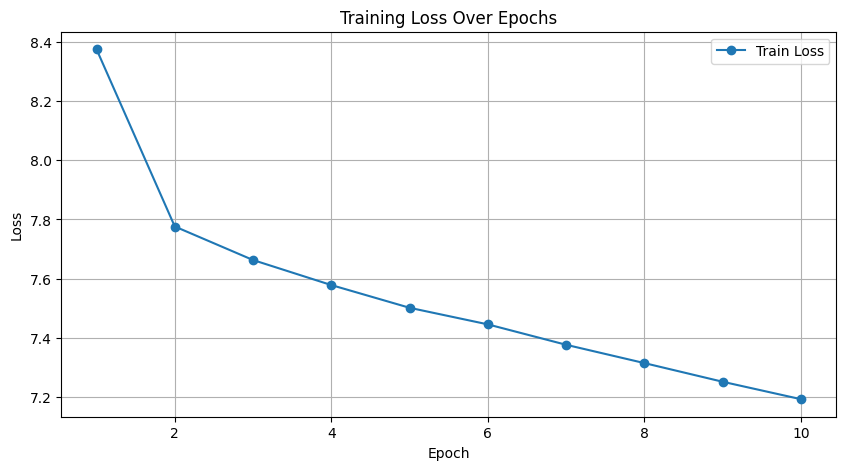

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define special tokens
special_tokens = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']

# Define functions to build vocabulary, tokenize, and pad sentences
def build_vocab(data):
    vocab = dict()
    for token in special_tokens:
        vocab[token] = len(vocab)
    for sentence in data:
        for word in sentence.split():
            if word.lower() not in vocab:
                vocab[word.lower()] = len(vocab)
    return vocab

def tokenize(vocab, data):
    tok_data = []
    for sentence in data:
        sentence_tok = [vocab['<SOS>']]
        for word in sentence.split():
            if word.lower() in vocab:
                sentence_tok.append(vocab[word.lower()])
            else:
                sentence_tok.append(vocab['<UNK>'])
        sentence_tok.append(vocab['<EOS>'])
        tok_data.append(sentence_tok)
    return tok_data

def pad_sentences(data, pad_token):
    max_len = max(len(sentence) for sentence in data)
    padded_data = []
    for sentence in data:
        while len(sentence) < max_len:
            sentence.append(pad_token)
        padded_data.append(sentence)
    return padded_data

# Load dataset
dataset = load_dataset("opus_books", 'en-fi')

def dataset_to_numpy(dataset):
    finnish_sentences = []
    english_sentences = []
    for example in dataset:
        finnish_sentences.append(example['translation']['fi'])
        english_sentences.append(example['translation']['en'])
    return finnish_sentences, english_sentences

# Preprocess data
finnish_data, english_data = dataset_to_numpy(dataset['train'])
en_vocab, fi_vocab = build_vocab(english_data), build_vocab(finnish_data)
en_data_tok, fi_data_tok = tokenize(en_vocab, english_data), tokenize(fi_vocab, finnish_data)

en_data_og = pad_sentences(en_data_tok, en_vocab['<PAD>'])
fi_data_og = pad_sentences(fi_data_tok, fi_vocab['<PAD>'])
en_data = np.array(en_data_og)
fi_data = np.array(fi_data_og)

# Convert data to tensors and create dataloaders
en_tensor = torch.tensor(en_data, dtype=torch.long)
fi_tensor = torch.tensor(fi_data, dtype=torch.long)

train_dataset = TensorDataset(en_tensor, fi_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define Encoder and Decoder classes
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden, cell

# Seq2Seq model combining Encoder and Decoder
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len = trg.shape[0]
        batch_size = trg.shape[1]
        trg_vocab_size = self.decoder.fc_out.out_features
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        hidden, cell = self.encoder(src)
        
        input = trg[0, :]
        
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            top1 = output.argmax(1)
            input = trg[t] if random.random() < teacher_forcing_ratio else top1
        
        return outputs

# Initialize model, loss function, and optimizer
INPUT_DIM = len(en_vocab)
OUTPUT_DIM = len(fi_vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# device = 'cpu'
print(device)
model = Seq2Seq(enc, dec, device).to(device)

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=en_vocab['<PAD>'])

# Training loop
def train(model, iterator, optimizer, criterion, clip, device):
    model.train()
    epoch_loss = 0
    
    for i, batch in enumerate(tqdm(iterator, desc="Training")):
        src, trg = batch
        src, trg = src.permute(1, 0).to(device), trg.permute(1, 0).to(device)
        
        optimizer.zero_grad()
        output = model(src, trg)
        
        output_dim = output.shape[-1]
        
        output = output[1:].reshape(-1, output_dim)
        trg = trg[1:].reshape(-1)
        
        loss = criterion(output, trg)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

# Training setup
N_EPOCHS = 10
CLIP = 1
train_losses = []

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion, CLIP, device)
    train_losses.append(train_loss)
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f}')

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, N_EPOCHS + 1), train_losses, marker='o', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()


In [ ]:
def translate_sentence(sentence, src_vocab, trg_vocab, model, device, max_len=50):
    model.eval()
    tokens = [token.lower() for token in sentence.split()]
    tokens = [src_vocab['<SOS>']] + [src_vocab.get(token, src_vocab['<UNK>']) for token in tokens] + [src_vocab['<EOS>']]
    
    src_tensor = torch.LongTensor(tokens).unsqueeze(1).to(device)
    
    with torch.no_grad():
        hidden, cell = model.encoder(src_tensor)
    
    trg_indexes = [trg_vocab['<SOS>']]
    
    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        
        with torch.no_grad():
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)
        
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        
        if pred_token == trg_vocab['<EOS>']:
            break
    
    trg_tokens = [list(trg_vocab.keys())[list(trg_vocab.values()).index(i)] for i in trg_indexes]
    
    return trg_tokens[1:-1]

# Translate a test sentence
test_sentence = "I am a chicken"
translation = translate_sentence(test_sentence, en_vocab, fi_vocab, model, device)
print(f'Translation: {" ".join(translation)}')

Translation: pilkalla
